In [5]:
%load_ext autoreload
%autoreload 2
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import GPR,MSD_functions
import numpy as np
import matplotlib.pyplot as plt
import Posterior_analysis as PA
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we will generate a test-dataset akin to the one in this paper:https://www.science.org/doi/10.1126/science.abn6583. We will generate values at a fine time-resolution compared to the one in the paper so we can see what the predictions do between observations

In [21]:
noise = [48,47,120] # nm
D = 2810  # nm^2/s
k = 1 / 0.177  # 1/s
Gamma = 2*D*np.sqrt(1/np.pi/k)
J = D*167/k
true_track,noisy_track = np.load("Data/true_track.npy"),np.load("Data/noisy_track.npy")
times = np.arange(len(noisy_track))*30


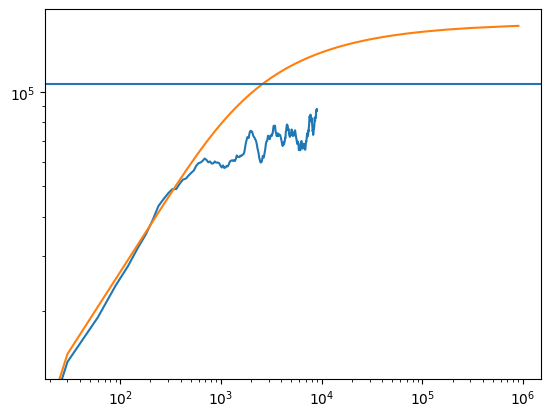

In [7]:
import utils
lags = np.arange(300)
msdval = utils.msd(true_track[None,:],lags)
plt.loglog(lags*(times[1]-times[0]),msdval[:,0],label='True MSD')
plt.loglog(np.arange(30_000)*(times[1]-times[0]),MSD_functions.Rouse_MSD(np.arange(30_000)*(times[1]-times[0]),np.array([Gamma,J])),label='Fitted MSD')
plt.axhline(2*np.nanmean(np.sum(true_track**2,axis=-1))/3)

We then perform posterior predictsions on the data to see how well we can recover the true underlying curve.

In [32]:


regressor = GPR.GPR(times,MSD_functions.Rouse_MSD,3)

x =  np.array([Gamma,J]+noise)
significant,statistic,block_sizes = PA.detect_anomalies(x,regressor,jnp.array(noisy_track),threshold=0.005)

100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


[Text(0, 0.5, 'Enhancer-promoter distance (nm)')]

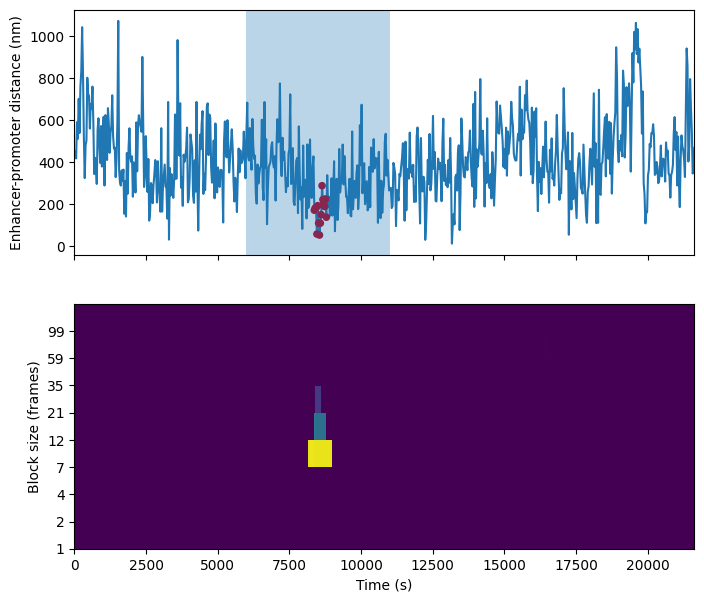

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(8,7), sharex=True)

ax[0].plot(times,np.linalg.norm(noisy_track, axis=-1), label='Noisy MSD',zorder=-1)
sc = ax[0].scatter(times,np.linalg.norm(noisy_track, axis=-1), c=significant[4],cmap="coolwarm",s=significant[4]*20)

ax[0].axvspan(times[200],times[200+167],alpha=0.3)
ax[1].imshow(statistic,aspect='auto',cmap='viridis',interpolation='none', extent=[times[0],times[-1],0,statistic.shape[0]])
_ = ax[1].set(yticks=np.arange(len(block_sizes)), yticklabels=block_sizes[::-1], xlabel='Time (s)', ylabel='Block size (frames)')
ax[0].set(ylabel='Enhancer-promoter distance (nm)')